# Compare stress decay
In this notebook I compare the decay of the bottom stress to 1D Ekman theory

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.special as special
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
files = [
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p06/snapshots/snapshots_1e-6_0p06_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p02/snapshots/snapshots_1e-7_0p02_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005_MS.h5',
        ]



flagfirst = True
tauya = []
S2a = []
Na = []
timea =[]
thta = []
for filename in files:
    print(filename)
    f = h5py.File(filename, 'r')
    
    N = f['tasks']['N'][0,0,0] #Interior stratification (background)
    tht = f['tasks']['tht'][0,0,0] # Slope angle
    thta.append(tht)
    Na.append(N)
    S2a.append(N**2*tht**2/1e-8)
    v = f['tasks']['v'] # Along-slope direction
    z = v.dims[2][0][:]
    time = v.dims[0][0][:]
    timea.append(time)
    vz = np.gradient(np.mean(v, axis=1), axis=-1)/np.gradient(z)
    # Calculate BEk
    tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS

    tauya.append(tauy)

    f.close()

/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1_MS.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2_MS.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p06/snapshots/snapshots_1e-6_0p06_MS.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01_MS.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p02/snapshots/snapshots_1e-7_0p02_MS.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005_MS.h5


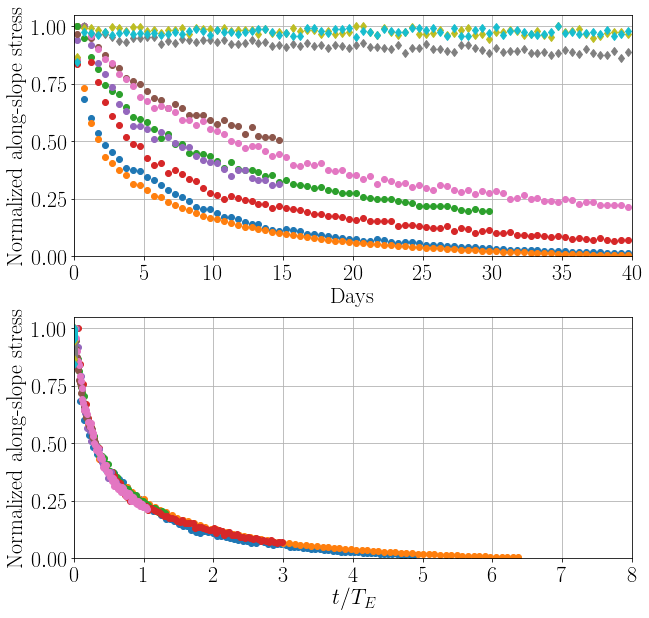

In [3]:
# Plot stresses as function of dimensional time, with rolling average
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

def moving_average(a, n=24) :
    #ret = np.cumsum(a, dtype=float)
    #ret[n:] = ret[n:] - ret[:-n]
    #return ret[n - 1:] / n
    nt = a.shape[0]
    nchunks = np.floor(nt/n)

    split = np.array_split(a, nchunks)
    return np.asarray([np.mean(a) for a in split])
nf = size(files)

fig, ax = plt.subplots(2,1, figsize=(10,10))
conv = 7 # run number where convection starts
for i in range(0,nf):
    tauval = np.mean(np.abs(tauya[i][1:36]))
    tauval = np.max(np.abs(moving_average(tauya[i])))
    if i < conv:
        ax[0].plot(moving_average(timea[i])/86400, np.abs(moving_average(tauya[i]))/tauval, marker='o', linestyle='', label=str(i))
    else:
        ax[0].plot(moving_average(timea[i])/86400, np.abs(moving_average(tauya[i]))/tauval, marker='d', linestyle='', label=str(i))
        
        #ax[0].legend()
ax[0].grid()
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Normalized along-slope stress')
ax[0].set_xlim(0, 40)
ax[0].set_ylim(0, 1.05)
for i in range(0,nf):
    if i == 4:
        Vi = 0.2
    else:
        Vi = 0.1
    tauval = np.mean(np.abs(tauya[i][1:36]))
    tauval = np.max(np.abs(moving_average(tauya[i])))
    #tauval = np.max(np.abs(tauya[i]))
    #tauval = 1035*1.5e-3*Vi**2
    if i < conv:
        Tscale = Vi**2*(1+S2a[i])**2/(2*Na[i]*S2a[i]**(3/2)*np.abs(tauval/1035))
        timend = timea[i]/Tscale
        ax[1].plot(moving_average(timend), np.abs(moving_average(tauya[i]))/tauval, marker='o', linestyle='')
    else:
        Tscale = Vi**2*(1+S2a[i])**1/(2*Na[i]*S2a[i]**(3/2)*np.abs(tauval/1035))
        timend = timea[i]/Tscale
        ax[1].plot(moving_average(timend), np.abs(moving_average(tauya[i]))/tauval, marker='d', linestyle='')
    #Tscale = (1+S2a[i])**2/(2*Na[i]*S2a[i]**(3/2)*2e-3)


    
ax[1].grid()
ax[1].set_xlabel('$t/T_E$')
ax[1].set_ylabel('Normalized along-slope stress')
ax[1].set_xlim(0, 8)
ax[1].set_ylim(0, 1.05)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('./MSFigs/BottomStress.pdf', bbox_inches='tight')

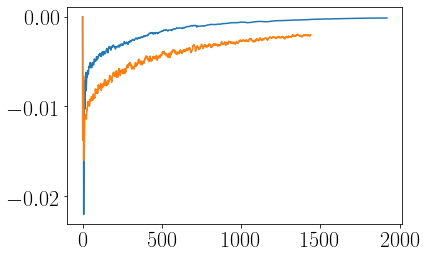

In [8]:
plt.plot(tauya[0])
plt.plot(tauya[2])

In [ ]:
# Plot stresses as function of dimensional time
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

nf = size(files)

fig, ax = plt.subplots(2,1, figsize=(10,10))

for i in range(0,nf):
    tauval = np.mean(np.abs(tauya[i][1:36]))

    ax[0].plot(timea[i]/86400, np.abs(tauya[i])/tauval, marker='x', linestyle='')

ax[0].grid()
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Normalized Stress magnitude')
ax[0].set_xlim(0, 45)
for i in range(0,nf):
    if i == 2:
        Vi = 0.2
    else:
        Vi = 0.1
    tauval = np.mean(np.abs(tauya[i][1:36]))
    #tauval = np.max(np.abs(tauya[i]))
    #tauval = 1035*1.5e-3*Vi**2
    Tscale = Vi**2*(1+S2a[i])**2/(2*Na[i]*S2a[i]**(3/2)*np.abs(tauval/1035))
    #Tscale = (1+S2a[i])**2/(2*Na[i]*S2a[i]**(3/2)*2e-3)

    timend = timea[i]/Tscale
    ax[1].plot(timend, np.abs(tauya[i])/tauval, marker='x')
    
ax[1].grid()
ax[1].set_xlabel('$t/T_E$')
ax[1].set_ylabel('Normalized Stress magnitude')
ax[1].set_xlim(0, 8)

#plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
#plt.savefig('NormalStress.png', bbox_inches='tight')

In [ ]:
plt.plot(timea[2]/86400, np.abs(tauya[2]))
plt.axhline(0.2**2*1035*1e-3)

In [ ]:
i=4
Tscale = Vi**2*(1+S2a[i])**2/(2*Na[i]*S2a[i]**(3/2)*np.abs(tauval/1035))

Tscale/86400

In [ ]:
# Calculate H vs H_E, ie with and without SI

runnum = 0

BekQ = tauya[runnum]/(1030*1e-4)*Na[runnum]**2*thta[runnum]
BekB= BekQ/(1+S2a[runnum])

nt = timea[runnum].size

toff = 12
Ho = 5
H2Q = np.zeros((nt, )) 
H2B = np.zeros((nt, )) 

for i in range(toff, nt):
    H2Q[i] = H2Q[i-1]+(2*-BekQ[i]/(Na[runnum]**2))*(timea[runnum][i]-timea[runnum][i-1])
    H2B[i] = H2B[i-1]+(2*-BekB[i]/(Na[runnum]**2))*(timea[runnum][i]-timea[runnum][i-1])
    
HQ = np.sqrt(Ho**2 + H2Q)
HQ[0:toff] = np.nan
HB = np.sqrt(Ho**2 + H2B)
HB[0:toff] = np.nan
plt.plot(timea[runnum]/86400, HQ)
plt.plot(timea[runnum]/86400, HB)
plt.plot(timea[runnum]/86400, HQ/np.sqrt(1+S2a[runnum]), linestyle='--')
plt.axhline(0.1*1e-4*(1+S2a[runnum])/(Na[runnum]**2*thta[runnum])) # arrest height (with SI)
plt.axhline(0.1*1e-4/(Na[runnum]**2*thta[runnum])) # arrest height (with SI)

In [ ]:
# CALCULATE NON-DIM H
# Noting that dH^2/dt^2 = phi(t), when everything is non-dimensional (regardless of SI or EK)

runnum = 0


nt = timea[runnum].size
Harr = 0.1*1e-4*(1+S2a[runnum])/(Na[runnum]**2*thta[runnum])
tauscale = np.mean(np.abs(tauya[runnum][1:36]))

Te = (1+S2a[runnum])**2*0.1**2/(2*Na[runnum]*S2a[runnum]**(3/2)*tauscale/1035)
toff = 12
Ho = 5/Harr
H2nd = np.zeros((nt, )) 
taund = tauya[runnum]/np.abs(tauscale)
timend = timea[runnum]/Te
for i in range(toff, nt):
    H2nd[i] = H2nd[i-1]-taund[i]*(timend[i]-timend[i-1])

Hnd = np.sqrt(Ho**2 + H2nd)
#plt.plot(timend, Hnd)

plt.plot(timend, Hnd*Harr)

In [ ]:
Te

In [ ]:
#Look at dissipation between the two cases (Ek vs. SI)
tauval = np.mean(np.abs(tauya[runnum][1:36]))

TscaleQ = Vi**2*(1+S2a[runnum])**2/(2*Na[runnum]*S2a[runnum]**(3/2)*np.abs(tauval/1035))
TscaleB = Vi**2*(1+S2a[runnum])**1/(2*Na[runnum]*S2a[runnum]**(3/2)*np.abs(tauval/1035))

epsSI = 1/6*Na[runnum]**2/(1+S2a[runnum])*HQ**3
epsEK = 1/6*Na[runnum]**2*HB**3


plt.plot(timea[runnum]/TscaleQ, epsSI)
plt.plot(timea[runnum]/TscaleB, epsEK)
#plt.plot(timea[runnum]/TscaleQ, epsSI/np.sqrt(1+S2a[runnum]), linestyle='--')
plt.axhline(((1+S2a[runnum])*0.1*1e-4/(Na[runnum]**2*thta[runnum]))**3*1/6*Na[runnum]**2)
plt.axhline((0.1*1e-4/(Na[runnum]**2*thta[runnum]))**3*1/6*Na[runnum]**2)

In [ ]:
((1+S2a[runnum])*0.1*1e-4/(Na[runnum]**2*thta[runnum]))
0.1*1e-4/(Na[runnum]**2*thta[runnum])

In [ ]:
i = 0
tauval = np.mean(np.abs(tauya[i][1:36]))
    
TscaleQ = Vi**2*(1+S2a[i])**2/(2*Na[i]*S2a[i]**(3/2)*np.abs(tauval/1035))
TscaleB = Vi**2*(1+S2a[i])**1/(2*Na[i]*S2a[i]**(3/2)*np.abs(tauval/1035))

print(f'T scale Q: {TscaleQ/86400},  T scale B: {TscaleB/86400}')


In [ ]:
Htemp = HQ
Htemp[np.isnan(Htemp)] = 0
integrate.trapz(Htemp*Na[runnum]**2*thta[runnum]/(1e-4*(1+S2a[runnum])), 
                x=timea[runnum])/(0.1*timea[runnum][-1])

plt.plot(timea[runnum]/86400, 1/6*Na[runnum]**2*thta[runnum]/(1+S2a[runnum])*HQ**3)
plt.plot(timea[runnum]/86400, -0.1*tauya[runnum])